In [1]:
import models
from models import model, create_cd_cluster, cd_diagram
from dataset_management import get_dataset, convert_to_autorank
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";budget="used_fidelity"

In [2]:
dataset=get_dataset(dataset_name="fig7_24_at25_bad_intsteps")
steps=[0,9,17,24]
dataset=dataset.loc[(dataset[budget]>min(steps))&(dataset[budget]<=max(steps))]
dataset=dataset.loc[dataset["prior"].isin(["at25","bad"])]
budget_slices={(steps[0],steps[1]):"low",(steps[1],steps[2]):"mid",(steps[2],steps[3]):"high"} # low, mid, high
budget_ord={(steps[0],steps[1]):1,(steps[1],steps[2]):3,(steps[2],steps[3]):10} # low, mid, high
def slicer(bud):
    for b in budget_slices.keys():
        if bud>b[0] and bud<=b[1]:
            #print(budget_slices[b],budget_ord[b])
            return [budget_slices[b],budget_ord[b]]
dataset[f"{budget}_group"],dataset[f"{budget}_ord"]=zip(*dataset[budget].apply(slicer))
dataset[f"{budget}_ord"]=dataset[f"{budget}_ord"].astype(float)

df_slices={}
for b_n,b in enumerate(budget_slices.keys()):
    df_slices[b_n]=dataset.loc[(dataset[budget]>b[0])&(dataset[budget]<=b[1])]
"""Cluster with 4 rows. Each row 3 CD diagrams with low, mid and high budget.
1st row: Autorank
2nd row: LMEM on slice (relative ranks)
3rd row: LMEM on slice (raw value)
4th row: LMEM on global, test on slice
5th row: Row 4, with budget weighing
"""
# Plot-cluster
fig, axs = plt.subplots(5, 3, figsize=(15, 12))
plt.close(fig)

In [3]:
def cd_row(row:int,lmem:bool,formula:str=None,globality:bool=False,loss:str="value"):
    if not lmem:
        for cell_n in range(len(axs[row])):
            axs[row][cell_n].cla()
            autorank_data=convert_to_autorank(df_slices[cell_n])
            autorank_res=autorank(autorank_data)
            cd_diagram(autorank_res,reverse=False,ax=axs[row][cell_n],width=5)
            axs[row][cell_n].set_title(f"{'Autorank' if autorank else 'LMEM'} ({loss}) {' (global/local)' if globality else ''} on slice {list(budget_slices.keys())[cell_n]}")
    else:
        if globality:
            post_hocs=model(formula=f"{loss}~{formula}",data=dataset,factor_list=["algorithm",f"{budget}_group"]).post_hoc(marginal_vars=algorithm,grouping_vars=f"{budget}_group")
            for cell_n in range(len(axs[row])):
                axs[row][cell_n].cla()
                post_hoc=(post_hocs[0].loc[post_hocs[0][f"{budget}_group"]==list(budget_slices.values())[cell_n]],post_hocs[1].loc[post_hocs[1][f"{budget}_group"]==list(budget_slices.values())[cell_n]])    
                cd_diagram(post_hoc,reverse=False,ax=axs[row][cell_n],width=5)
                axs[row][cell_n].set_title(f"{'Autorank' if autorank else 'LMEM'} ({loss}) {' (global/local)' if globality else ''} on slice {list(budget_slices.keys())[cell_n]}")
        else:
            for cell_n in range(len(axs[row])):
                axs[row][cell_n].cla()
                post_hocs=model(formula=f"{loss}~{formula}",data=df_slices[cell_n]).post_hoc(marginal_vars=algorithm)
                cd_diagram(post_hocs,reverse=False,ax=axs[row][cell_n],width=5)
                axs[row][cell_n].set_title(f"{'Autorank' if not lmem else 'LMEM'} ({loss}) {' (global/local)' if globality else ''} on slice {list(budget_slices.keys())[cell_n]}")


In [4]:
#Row 1
cd_row(0,False)


c:\Users\lenak\OFFLINE_FILES\Anton\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\lenak\OFFLINE_FILES\Anton\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\lenak\OFFLINE_FILES\Anton\Git\significance_analysis\.venv_3_10_0\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [5]:
#Row 2
cd_row(1,True,f"{algorithm}",globality=False,loss="value")

boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates


In [6]:
#Row 3
cd_row(2,True,f"{algorithm}+(1|{benchmark})",globality=False,loss="regret")


P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates
P-values adjusted by tukey method for family of 10 estimates


In [7]:
#Row 4
cd_row(3,True,f"{algorithm}+{benchmark}+{budget}_group",globality=True,loss="value")

boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates


boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 10 estimates


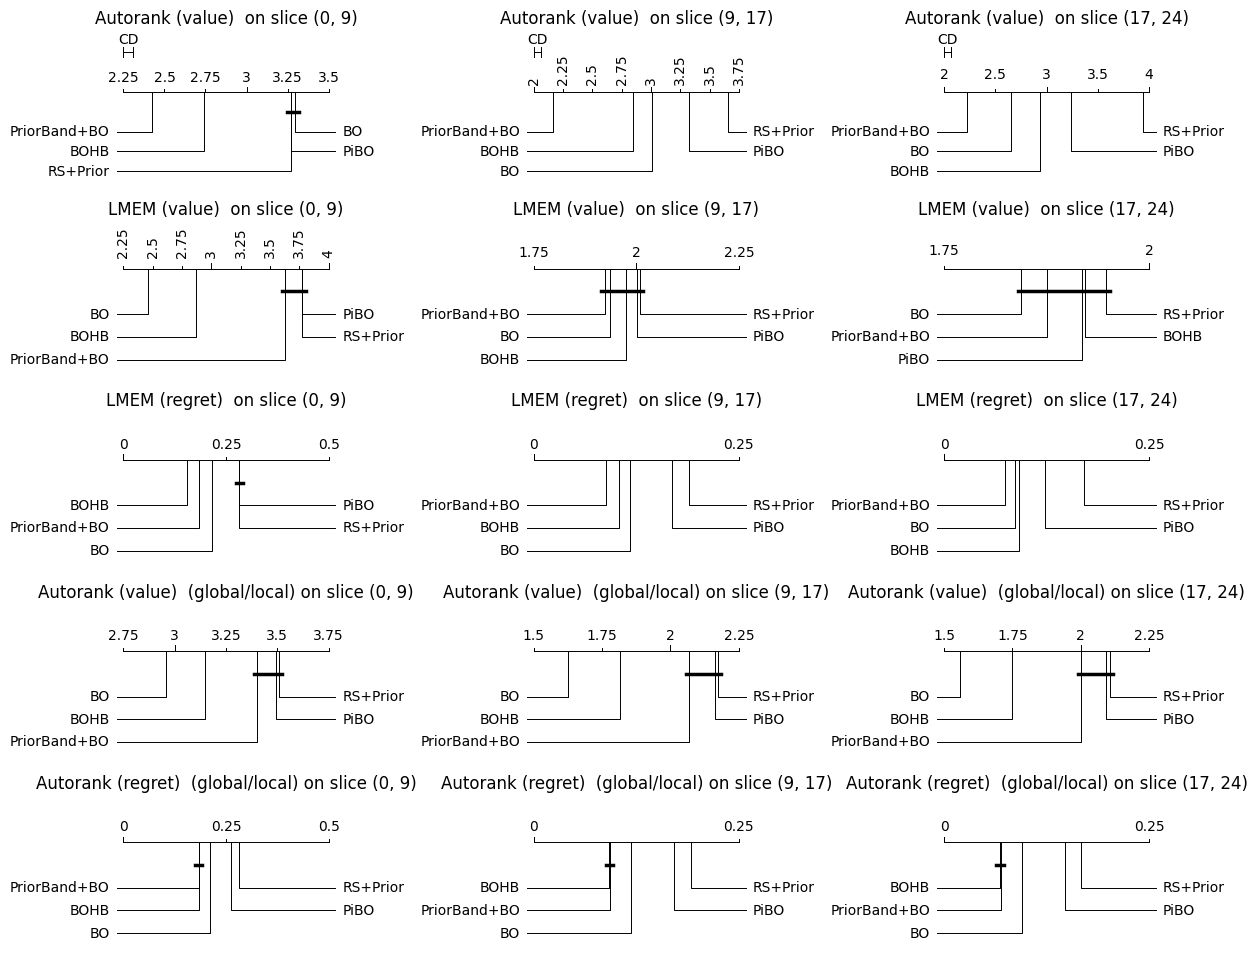

In [8]:
#Row 5
cd_row(4,True,f"{algorithm}+{benchmark}+{budget}_group",globality=True,loss="regret")
fig